In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.feature_selection import VarianceThreshold, SelectKBest,RFE, SelectFromModel

import warnings
warnings.filterwarnings("ignore")

## 特征工程

### 1.特征选择
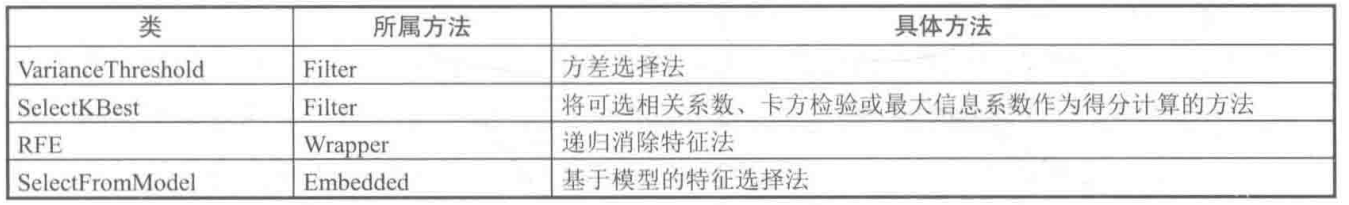

In [33]:
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target
X


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


<b>方差过滤</b>

In [14]:
# 方差过滤
vt = VarianceThreshold().fit(X)
vt.variances_

array([0.68112222, 0.18871289, 3.09550267, 0.57713289])

In [15]:
pd.DataFrame(VarianceThreshold(0.2).fit_transform(X)) # 过滤了X的第二列数据

,0,1,2
0,5.1,1.4,0.2
1,4.9,1.4,0.2
2,4.7,1.3,0.2
3,4.6,1.5,0.2
4,5.0,1.4,0.2
...,...,...,...
145,6.7,5.2,2.3
146,6.3,5.0,1.9
147,6.5,5.2,2.0
148,6.2,5.4,2.3


<b>pearson相关系数：</b>  
stats.pearsonr([1,2,3],[2,2,3])  
PearsonRResult(statistic=0.8660254037844385, pvalue=0.3333333333333336)   
statistic 是两个变量的相关系数  
pvalue的范围在0到1之间。当p值接近0时，表示两个变量之间存在较强的线性关系；当p值接近1时，表示两个变量之间的线性关系较弱。通常，我们会设定一个显著性水平（例如0.05），如果计算得到的p值小于这个水平，我们就认为两个变量之间存在显著的线性关系。  

In [40]:
from scipy import stats
stats.pearsonr([2.5,5,0,2,3],[3,5,0,2,3])

PearsonRResult(statistic=0.9923953268977466, pvalue=0.0007951675750153208)

In [67]:
# 相关系数法
def f_corrcoef(X, Y): 
    res_list = list(map(lambda x: stats.pearsonr(x,y), X.T)) 
    res_array = np.array(res_list).T
    return res_array[0], res_array[1] #相关系数，p值
print(f_corrcoef(X.values, y))
pd.DataFrame( SelectKBest(f_corrcoef, k=3).fit_transform(X, y) )

(array([ 0.78256123, -0.42665756,  0.9490347 ,  0.95654733]), array([2.89047835e-32, 5.20156326e-08, 4.20187315e-76, 4.15531102e-81]))


,0,1,2
0,5.1,1.4,0.2
1,4.9,1.4,0.2
2,4.7,1.3,0.2
3,4.6,1.5,0.2
4,5.0,1.4,0.2
...,...,...,...
145,6.7,5.2,2.3
146,6.3,5.0,1.9
147,6.5,5.2,2.0
148,6.2,5.4,2.3


<b>卡方检验</b>  
参考： http://pointborn.com/article/2023/1/3/2065.html

回想一下，卡方检验可测量随机变量之间的相关性，因此使用此功能可以“淘汰”最有可能与类别(target)无关的特征。  
零假设：变量Vi符合Target分布
p值<0.05则推翻零假设，说明Vi与Target无关
p值越大于0.05则越有零假设成立，说明Vi与Target相关

In [38]:
from scipy.stats import chisquare

observed = [2,5,1,21,29] # 观察的频数
expected = [2,5,1,20,30] # 真实频数

output = chisquare(observed, expected)
output

Power_divergenceResult(statistic=0.08333333333333334, pvalue=0.9991556844886856)

In [74]:
from sklearn.feature_selection import chi2

chi2_values,p_values = chi2(X, y) # 卡方值， p值
print(chi2_values)             
print(np.around(p_values, 7))  

pd.DataFrame( SelectKBest(chi2, k=3).fit_transform(X, y) )

[ 10.81782088   3.7107283  116.31261309  67.0483602 ]
[0.0044765 0.156396  0.        0.       ]


,0,1,2
0,5.1,1.4,0.2
1,4.9,1.4,0.2
2,4.7,1.3,0.2
3,4.6,1.5,0.2
4,5.0,1.4,0.2
...,...,...,...
145,6.7,5.2,2.3
146,6.3,5.0,1.9
147,6.5,5.2,2.0
148,6.2,5.4,2.3


<b>递归特征消除法</b>  
执行流程：  
1. 初始的特征集为所有可用的特征。
2. 使用当前特征集进行建模，然后计算每个特征的重要性。
3. 删除最不重要的一个（或多个）特征，更新特征集。
4. 跳转到步骤2，直到完成所有特征的重要性评级。

In [82]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', max_iter=500)
lr.fit(X,y)
lr.coef_ # (n_classes, n_features) 每个分类中，各个特征的重要系数


array([[-0.42434519,  0.96692806, -2.51720846, -1.07938946],
       [ 0.53499003, -0.32132698, -0.20620328, -0.94424639],
       [-0.11064484, -0.64560109,  2.72341174,  2.02363584]])

逻辑回归模型的coef_属性是一个一维数组，包含每个特征的系数，这些系数表示特征对于分类结果的影响程度。   
具体来说，coef_数组中的每个元素表示对应特征的系数，正系数表示该特征对分类结果的影响是正向的，负系数表示该特征对分类结果的影响是负向的，系数的绝对值越大，则表示该特征对分类结果的影响越大。

In [83]:
RFE(estimator=LogisticRegression(solver='lbfgs', max_iter=500),
   n_features_to_select=3).fit_transform(X,y)

# 这里把第一列删除了（认为第一列不重要）

array([[3.5, 1.4, 0.2],
       [3. , 1.4, 0.2],
       [3.2, 1.3, 0.2],
       [3.1, 1.5, 0.2],
       [3.6, 1.4, 0.2],
       [3.9, 1.7, 0.4],
       [3.4, 1.4, 0.3],
       [3.4, 1.5, 0.2],
       [2.9, 1.4, 0.2],
       [3.1, 1.5, 0.1],
       [3.7, 1.5, 0.2],
       [3.4, 1.6, 0.2],
       [3. , 1.4, 0.1],
       [3. , 1.1, 0.1],
       [4. , 1.2, 0.2],
       [4.4, 1.5, 0.4],
       [3.9, 1.3, 0.4],
       [3.5, 1.4, 0.3],
       [3.8, 1.7, 0.3],
       [3.8, 1.5, 0.3],
       [3.4, 1.7, 0.2],
       [3.7, 1.5, 0.4],
       [3.6, 1. , 0.2],
       [3.3, 1.7, 0.5],
       [3.4, 1.9, 0.2],
       [3. , 1.6, 0.2],
       [3.4, 1.6, 0.4],
       [3.5, 1.5, 0.2],
       [3.4, 1.4, 0.2],
       [3.2, 1.6, 0.2],
       [3.1, 1.6, 0.2],
       [3.4, 1.5, 0.4],
       [4.1, 1.5, 0.1],
       [4.2, 1.4, 0.2],
       [3.1, 1.5, 0.2],
       [3.2, 1.2, 0.2],
       [3.5, 1.3, 0.2],
       [3.6, 1.4, 0.1],
       [3. , 1.3, 0.2],
       [3.4, 1.5, 0.2],
       [3.5, 1.3, 0.3],
       [2.3, 1.3

<b>SelectFromModel 嵌入法</b>  
基于模型的特征选择法

In [86]:
# 基于LogisticRegression
SelectFromModel(LogisticRegression(solver='lbfgs', C=0.1, max_iter=500)).fit_transform(X,y)

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.7, 0.4],
       [1.4, 0.3],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.5, 0.1],
       [1.5, 0.2],
       [1.6, 0.2],
       [1.4, 0.1],
       [1.1, 0.1],
       [1.2, 0.2],
       [1.5, 0.4],
       [1.3, 0.4],
       [1.4, 0.3],
       [1.7, 0.3],
       [1.5, 0.3],
       [1.7, 0.2],
       [1.5, 0.4],
       [1. , 0.2],
       [1.7, 0.5],
       [1.9, 0.2],
       [1.6, 0.2],
       [1.6, 0.4],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.6, 0.2],
       [1.6, 0.2],
       [1.5, 0.4],
       [1.5, 0.1],
       [1.4, 0.2],
       [1.5, 0.2],
       [1.2, 0.2],
       [1.3, 0.2],
       [1.4, 0.1],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.3, 0.3],
       [1.3, 0.3],
       [1.3, 0.2],
       [1.6, 0.6],
       [1.9, 0.4],
       [1.4, 0.3],
       [1.6, 0.2],
       [1.4, 0.2],
       [1.5, 0.2],
       [1.4, 0.2],
       [4.7, 1.4],
       [4.5, 1.5],
       [4.9,

In [87]:
# 基于GBDT
from sklearn.ensemble import GradientBoostingClassifier as GBDT
SelectFromModel(GBDT()).fit_transform(X,y)

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.7, 0.4],
       [1.4, 0.3],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.5, 0.1],
       [1.5, 0.2],
       [1.6, 0.2],
       [1.4, 0.1],
       [1.1, 0.1],
       [1.2, 0.2],
       [1.5, 0.4],
       [1.3, 0.4],
       [1.4, 0.3],
       [1.7, 0.3],
       [1.5, 0.3],
       [1.7, 0.2],
       [1.5, 0.4],
       [1. , 0.2],
       [1.7, 0.5],
       [1.9, 0.2],
       [1.6, 0.2],
       [1.6, 0.4],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.6, 0.2],
       [1.6, 0.2],
       [1.5, 0.4],
       [1.5, 0.1],
       [1.4, 0.2],
       [1.5, 0.2],
       [1.2, 0.2],
       [1.3, 0.2],
       [1.4, 0.1],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.3, 0.3],
       [1.3, 0.3],
       [1.3, 0.2],
       [1.6, 0.6],
       [1.9, 0.4],
       [1.4, 0.3],
       [1.6, 0.2],
       [1.4, 0.2],
       [1.5, 0.2],
       [1.4, 0.2],
       [4.7, 1.4],
       [4.5, 1.5],
       [4.9,

### 2.线性降维
1）PCA （主成分分析分）  
2）LDA （线性判别分析法）

In [89]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit_transform(X)

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943],
       [-2.74534286, -0.31829898],
       [-2.72871654,  0.32675451],
       [-2.28085963,  0.74133045],
       [-2.82053775, -0.08946138],
       [-2.62614497,  0.16338496],
       [-2.88638273, -0.57831175],
       [-2.6727558 , -0.11377425],
       [-2.50694709,  0.6450689 ],
       [-2.61275523,  0.01472994],
       [-2.78610927, -0.235112  ],
       [-3.22380374, -0.51139459],
       [-2.64475039,  1.17876464],
       [-2.38603903,  1.33806233],
       [-2.62352788,  0.81067951],
       [-2.64829671,  0.31184914],
       [-2.19982032,  0.87283904],
       [-2.5879864 ,  0.51356031],
       [-2.31025622,  0.39134594],
       [-2.54370523,  0.43299606],
       [-3.21593942,  0.13346807],
       [-2.30273318,  0.09870885],
       [-2.35575405, -0.03728186],
       [-2.50666891, -0.14601688],
       [-2.46882007,  0.13095149],
       [-2.56231991,  0.36771886],
       [-2.63953472,

In [90]:
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])